In [4]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.font_manager as fm
font_path = "/content/drive/MyDrive/IT2022/Montserrat-Medium.ttf"
fm.fontManager.addfont(font_path)

Mounted at /content/drive


In [5]:
import numpy as np
import tensorflow as tf
import torch
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
class SMOTETensorFlow:
    def __init__(self, k_neighbors=5):
        self.k_neighbors = k_neighbors

    def fit_resample(self, X, y):
        """
        Resample the dataset using SMOTE with TensorFlow.

        Args:
            X: Input features (numpy array)
            y: Target labels (numpy array)

        Returns:
            X_resampled: Resampled features
            y_resampled: Resampled labels
        """
        # Convert inputs to TensorFlow tensors
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.int32)

        # Find minority class samples
        unique_labels, counts = np.unique(y.numpy(), return_counts=True)
        minority_label = unique_labels[np.argmin(counts)]
        minority_mask = (y.numpy() == minority_label)
        minority_samples = X[minority_mask]

        # Find majority class samples
        majority_samples = X[y != minority_label]

        # Calculate number of synthetic samples to generate
        n_minority = tf.shape(minority_samples)[0]
        n_majority = tf.shape(majority_samples)[0]
        n_synthetic = n_majority - n_minority

        # Find k-nearest neighbors for each minority sample
        knn = NearestNeighbors(n_neighbors=self.k_neighbors)
        knn.fit(minority_samples.numpy())
        _, indices = knn.kneighbors(minority_samples.numpy())


        # Generate synthetic samples
        synthetic_samples = []
        for i in range(n_synthetic):
            # Randomly select a minority sample
            idx = tf.random.uniform([], 0, n_minority, dtype=tf.int32)
            sample = minority_samples[idx]

            # Randomly select a neighbor
            neighbor_idx = tf.random.uniform([], 0, self.k_neighbors, dtype=tf.int32)
            neighbor = minority_samples[indices[idx][neighbor_idx]]

            # Generate synthetic sample
            diff = neighbor - sample
            gap = tf.random.uniform([], 0, 1, dtype=tf.float32)
            synthetic = sample + gap * diff
            synthetic_samples.append(synthetic)

        # Combine original and synthetic samples
        X_resampled = tf.concat([X, tf.stack(synthetic_samples)], axis=0)
        y_resampled = tf.concat([y, tf.fill([n_synthetic], minority_label)], axis=0)

        return X_resampled.numpy(), y_resampled.numpy()

In [7]:
path = '/content/drive/MyDrive/IT2022/creditcard.csv'
df = pd.read_csv(path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
print(f"Train: {X_train.shape}, {y_train.shape}")

Train: (170884, 30), (170884,)


In [9]:
smote_tf = SMOTETensorFlow(k_neighbors=5)
X_train_resampled_tf, y_train_resampled_tf = smote_tf.fit_resample(X_train, y_train)
print("TensorFlow SMOTE - Original train shape:", X_train.shape, "Resampled train shape:", X_train_resampled_tf.shape)

TensorFlow SMOTE - Original train shape: (170884, 30) Resampled train shape: (341178, 30)


In [10]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_resampled_tf, y_train_resampled_tf))

In [11]:
name = df.columns.tolist()
name.remove('Class')

In [12]:
resampled_df_train = pd.DataFrame(X_train_resampled_tf, columns=[f'{i}' for i in name])
resampled_df_train['Class'] = y_train_resampled_tf

In [13]:
resampled_df_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,71174.0,-2.108259,1.173406,1.614294,0.482867,0.067209,-0.191013,0.191246,-1.705859,-0.177615,...,1.520625,-0.388595,0.260114,0.340667,0.400474,-0.413089,-0.348291,0.215298,19.99,0
1,169683.0,2.313997,-1.311064,-1.421228,-1.724356,-1.003480,-0.912621,-0.898765,-0.221952,-1.658076,...,0.089446,0.664605,0.029245,-0.347503,0.069152,0.074159,-0.024483,-0.076422,15.00,0
2,111127.0,2.104946,0.155284,-1.402870,0.311489,0.504248,-0.690870,0.138943,-0.417801,1.894584,...,0.107745,0.759527,-0.022144,0.465282,0.402861,-0.478955,-0.016524,-0.053868,1.00,0
3,152052.0,2.072408,-0.015687,-1.310880,0.373435,-0.063476,-1.380722,0.243699,-0.394350,0.631048,...,0.243262,0.858393,0.003403,0.077370,0.259102,-0.110464,-0.021166,-0.058972,1.99,0
4,123008.0,2.046409,0.156335,-2.006987,0.384525,0.604029,-0.756561,0.232367,-0.230789,0.072474,...,0.326565,1.165945,-0.109465,0.793698,0.377195,0.837559,-0.075171,-0.053246,1.57,0


Text(0.5, 0, 'Phan loai giao dich')

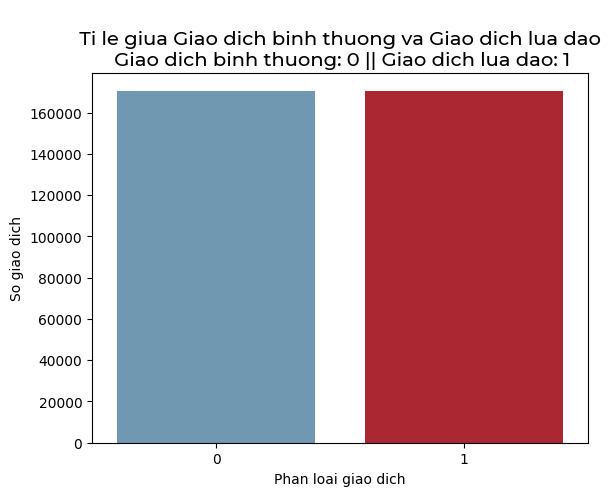

In [14]:
#Dep truoc da roi tinh sau
colors = ["#669BBC", "#C1121F"]
font = {'family':'Montserrat','color':'black','size':14}

sns.countplot(x='Class', hue = 'Class', data=resampled_df_train, palette=colors, legend = False)
plt.title('\n Ti le giua Giao dich binh thuong va Giao dich lua dao \n Giao dich binh thuong: 0 || Giao dich lua dao: 1',fontdict=font)
plt.ylabel("So giao dich")
plt.xlabel("Phan loai giao dich")

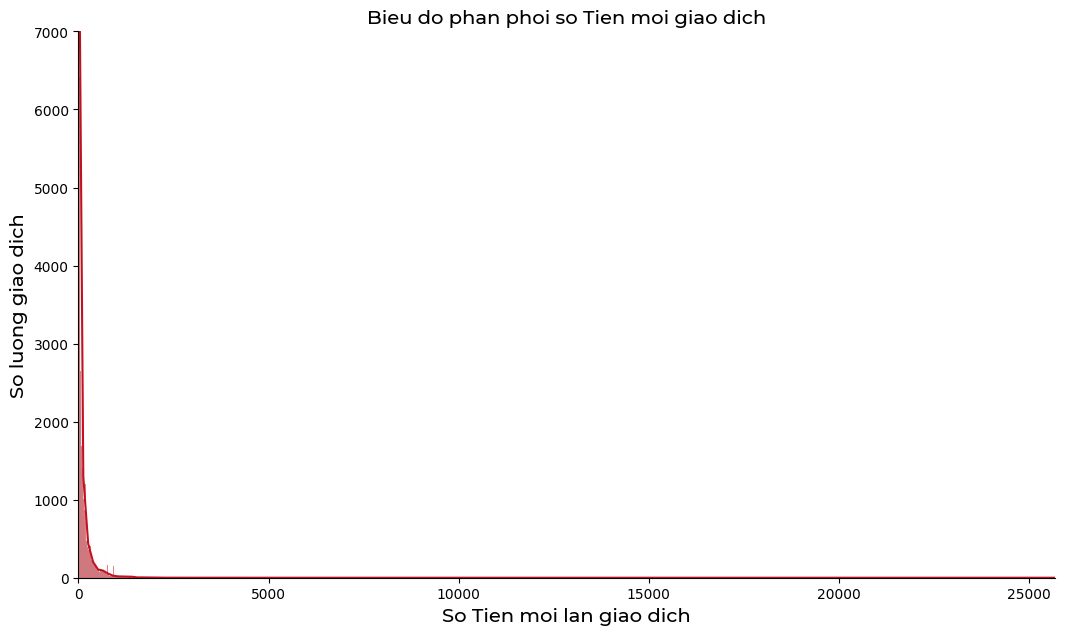

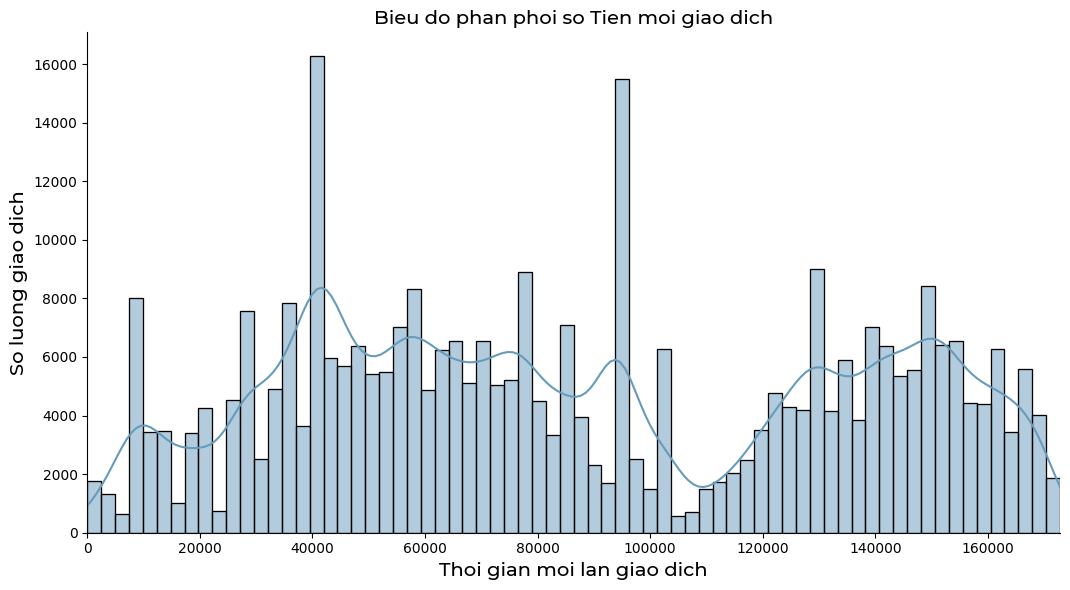

In [15]:
amount_val = resampled_df_train['Amount'].values

# Biểu đồ phân phối Số tiền
sns.displot(amount_val, color='#C1121F', kde =True, height = 6,aspect =1.8)
plt.title('Bieu do phan phoi so Tien moi giao dich', fontdict = font)
plt.ylabel('So luong giao dich', fontdict = font)
plt.xlabel('So Tien moi lan giao dich', fontdict = font)
plt.xlim([min(amount_val), max(amount_val)])
plt.ylim([0,7000])

time_val = resampled_df_train['Time'].values

# Biểu đồ phân phối Thời gian
sns.displot(time_val, color='#669BBC', kde =True, height = 6,aspect =1.8)
plt.title('Bieu do phan phoi so Tien moi giao dich', fontdict=font)
plt.ylabel('So luong giao dich', fontdict = font)
plt.xlabel('Thoi gian moi lan giao dich', fontdict = font)
plt.xlim([min(time_val), max(time_val)])


plt.tight_layout()
plt.show()


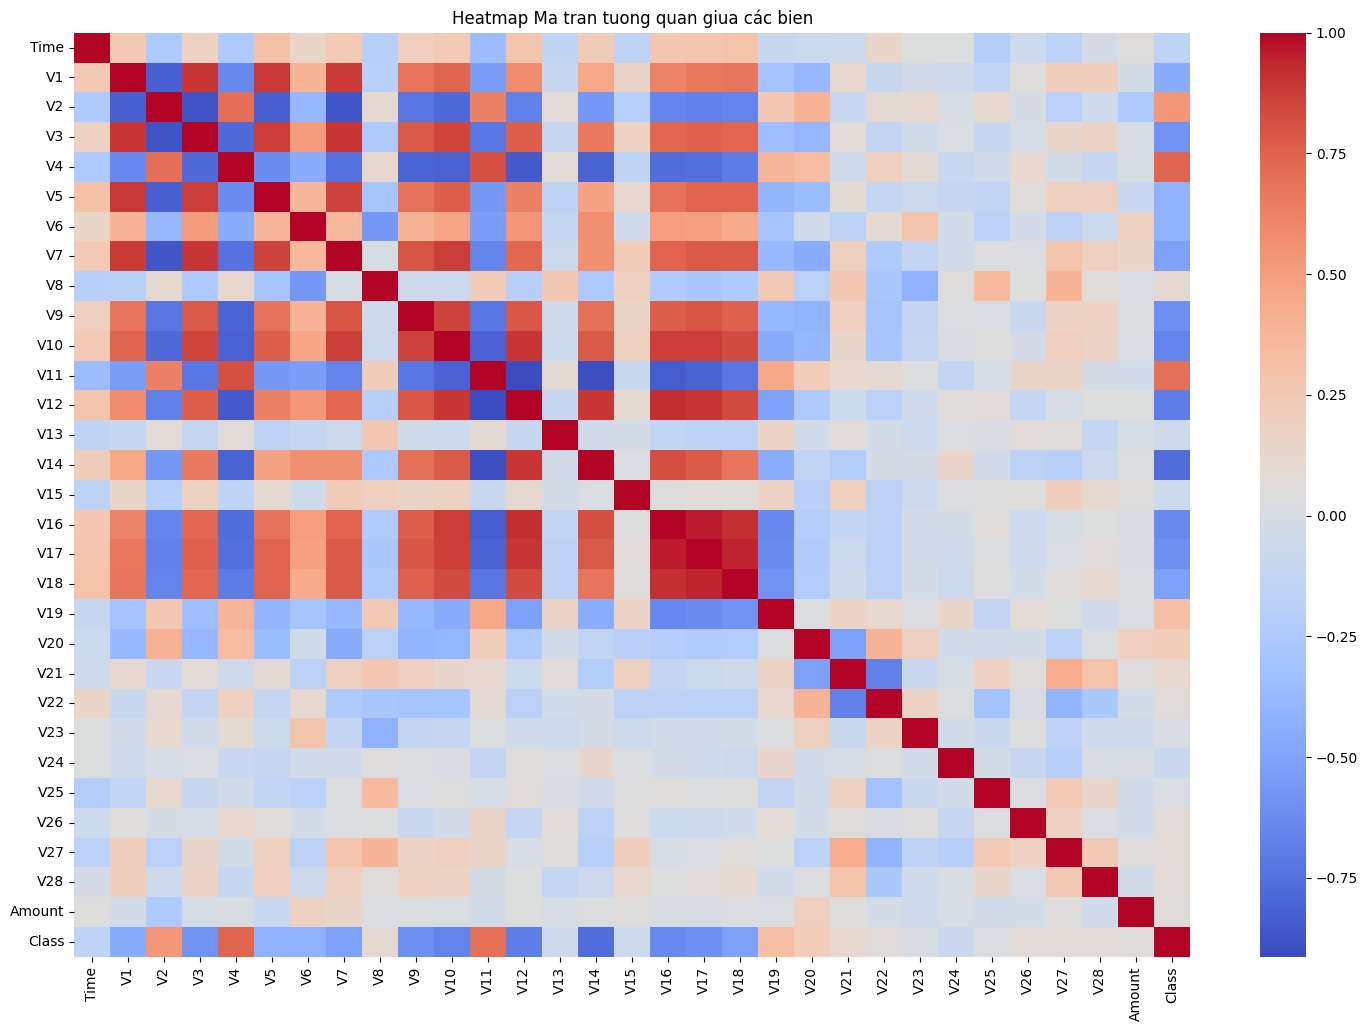

In [16]:
plt.figure(figsize=(18, 12))
corr = resampled_df_train.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f')
plt.title("Heatmap Ma tran tuong quan giua các bien")
plt.show()



In [17]:
resampled_df_train.to_csv('SMOTEd_creditcard_data_for_train.csv', index=False)

In [18]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [19]:
resampled_df_val = pd.DataFrame(X_val, columns=[f'{i}' for i in name])
resampled_df_val['Class'] = y_val

In [20]:
resampled_df_val.to_csv('SMOTEd_creditcard_data_for_validate.csv', index=False)

In [21]:
resampled_df_test = pd.DataFrame(X_test, columns=[f'{i}' for i in name])
resampled_df_test['Class'] = y_test

In [22]:
resampled_df_test.to_csv('SMOTEd_creditcard_data_for_test.csv', index=False)